# Problem 6.2
Attributions: Michelle

First we import our numerical workhorses and load our data set into a `DataFrame`.

In [33]:
# Our numerical workhorses
import warnings
import numpy as np
import pandas as pd
import scipy.signal
import scipy.special
import scipy.stats as st

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import corner

# Let plots show up on jupyter notebooks
%matplotlib inline

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')


# Justin's favorite settings
rc = {'lines.linewidth': 2,
      'axes.labelsize': 18,
      'axes.titlesize': 18,
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

df = pd.read_csv('./data/H930start2filt.txt', comment = '#', sep = '\t', names=['t (ms)', 'V (µV)'], header = None)


# a) & b)
First we want to change the time from miliseconds to seconds. Then we want to look at my data in order to determine the two types of spikes. 

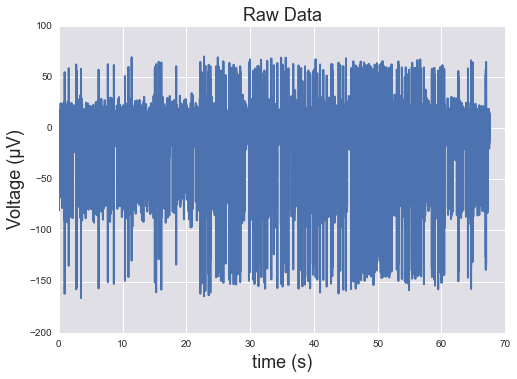

In [26]:
# change time to seconds
df['t (ms)'] /= 1000
df = df.rename(columns= {'t (ms)' : 't (s)'})

# plot our data to look at it
plt.plot(df['t (s)'], df['V (µV)'], zorder = 2)
plt.xlabel('time (s)')
plt.ylabel('Voltage (µV)')
plt.title("Raw Data")

It's hard to tell from this graph the two types of spikes recorded. In order to make this observation we decided to isolate the spikes first. After examination of the spikes in the graph above, we set our threshold to be -55 µV. We set a time window of a total of 25 sample points and assume that the minimum of the spike is located at the average of the times where the spike crosses the down and up thresholds.

In [7]:
# now we want to find local minima and maximas using what 
#we discussed in class we can define a threshold
thresh = -55
V = df['V (µV)'].values

# down will give us the value for the point where the threshold is 
#crossed from the right up will give us the value for the point where 
#the threshold is crossed from the left the spike will be in between 
#down and up

down = np.where(np.logical_and(V[:-1] > thresh, V[1:] < thresh))[0]
up = np.where(np.logical_and(V[:-1] < thresh, V[1:] > thresh))[0]

# now i want to set windows around these local minimums
time_window_L = 0.0005
time_window_R = 0.002

# We want to convert our time window to number of samples
inter_sample_time = df['t (s)'][1] - df['t (s)'][0]
sampling_frequency = 1 / inter_sample_time

left_window = int(time_window_L * sampling_frequency)
right_window = int(time_window_R * sampling_frequency)

# create a DataFrame to later store our spike values and 
#their surroundings (i.e. the time window on either side)
df_min = pd.DataFrame(columns =['t (s)', 'V (µV)', 'spike'])

# we know that the spike is in the middle of the up and down 
#values calulated so we can calculate our spike that way

i = 0
for i in range(len(down)):
    t_min = df['t (s)'][down[i] - left_window:up[i] + right_window]
    V_min = df['V (µV)'][down[i] - left_window:up[i] + right_window]
    data={'t (s)': t_min, 'V (µV)': V_min, 
          'spike': int((down[i] + up[i]) / 2) * np.ones_like(t_min, dtype=int)}
    df_data = pd.DataFrame(data)
    df_min = pd.concat((df_min, df_data))
    i += 1

Let's plot the spikes now.

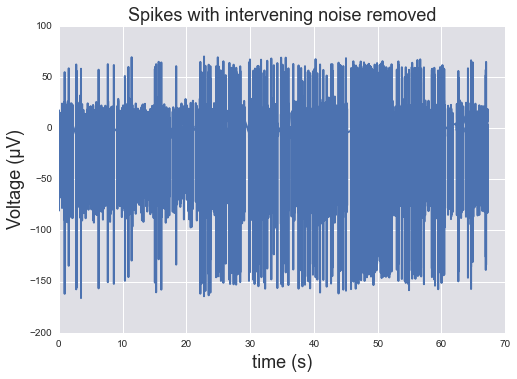

In [6]:
# Now to look at it and determine the two types of spikes
plt.plot(df_min['t (s)'], df_min['V (µV)'])
plt.xlabel('time (s)')
plt.ylabel('Voltage (µV)')
plt.title("Spikes with intervening noise removed")

Here we have removed all of the noise and are left with only the spikes. Zooming in on this graph we can see that there are two types of spikes. Type A spikes will depolarize and then repolarize a significant amount past zero before finally returning to zero, whereas Type B will depolarize and return to zero, or around there. 

To automatically differentiate between the two spikes, we will identify the spikes that are type A by mimicking what we did to locate the spikes. We set a positive threshold of 32 and keep the same 25 sample time window we used earlier. 

In [8]:
# now we want to find local minima and maximas using what we discussed in class
# we can define a threshold
thresh_max = 32
V_max = df_min['V (µV)'].values
down_max = np.where(np.logical_and(V_max[:-1] > \
                                   thresh_max, V_max[1:] < thresh_max))[0]
up_max = np.where(np.logical_and(V_max[:-1] < \
                                 thresh_max, V_max[1:] > thresh_max))[0]


# now that we have a down and up value to find the minimum we can 
#assume to take the average of the down and up value
local_max = (down_max + up_max) / 2

# now we want to set windows around these local minimums
time_window_L_max = 0.001
time_window_R_max = 0.0015

inter_sample_time = df['t (s)'][1] - df['t (s)'][0]
sampling_frequency = 1 / inter_sample_time

left_window_max = int(time_window_L_max * sampling_frequency)
right_window_max = int(time_window_R_max * sampling_frequency)

df_max = pd.DataFrame(columns=['t (s)', 'V (µV)', 'spike'])
j = 0
for j in range(len(up_max)):
    t_max = df_min['t (s)'][up_max[j] - \
                            left_window_max:down_max[j] + right_window_max]
    V_max = df_min['V (µV)'][up_max[j] - \
                             left_window_max:down_max[j] + right_window_max]
    data_max = {'t (s)': t_max, 'V (µV)': V_max, 
                'spike': int((down_max[j] + up_max[j]) / 2) \
                * np.ones_like(t_max, dtype=int)}
    df_data_max = pd.DataFrame(data_max)
    df_max = pd.concat((df_max, df_data_max))
    j += 1

Let's plot the type A spikes to see what they look like.

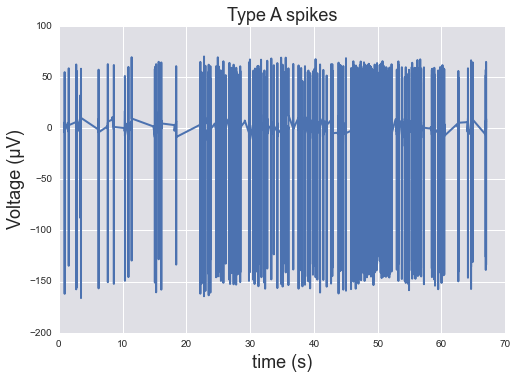

In [9]:
# plot to see what it looks like
plt.plot(df_max['t (s)'], df_max['V (µV)'])
plt.xlabel('time (s)')
plt.ylabel('Voltage (µV)')
plt.title('Type A spikes')

Now that we have located the Type A spikes we want to create two `DataFrames` for each of the two types of spikes. We can do this using the `.isin` function.

(-200, 100)

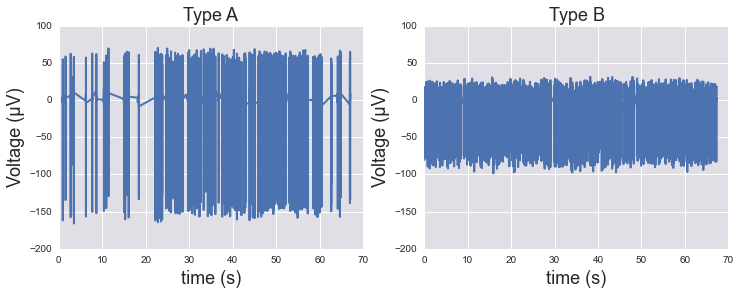

In [10]:
# now i want to seperate out my type b spikes
df_type_b = df_min[df_min['t (s)'].isin(df_max['t (s)']) == False]
df_type_a = df_min[df_min['t (s)'].isin(df_type_b['t (s)']) == False]

# let's plot the two graphs
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Type A
ax[0].plot(df_type_a['t (s)'], df_type_a['V (µV)'])
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('Voltage (µV)')
ax[0].set_title('Type A')

# Type B
ax[1].plot(df_type_b['t (s)'], df_type_b['V (µV)'])
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('Voltage (µV)')
ax[1].set_title('Type B')
ax[1].set_ylim(-200,100)


We can overlap these plots to compare the two types of spikes relative to each other.

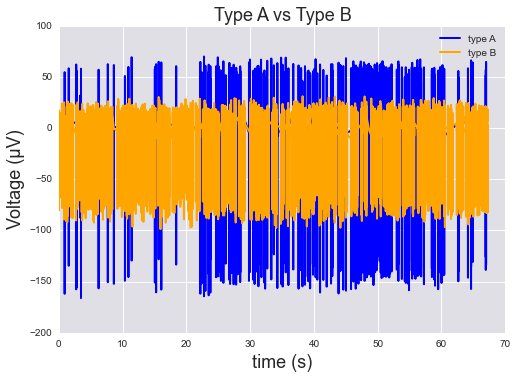

In [27]:
plt.plot(df_type_a['t (s)'], df_type_a['V (µV)'], color = 'blue')
plt.plot(df_type_b['t (s)'], df_type_b['V (µV)'], color = 'orange')
plt.xlabel('time (s)')
plt.ylabel('Voltage (µV)')
plt.legend(('type A', 'type B'), loc='upper right')
plt.title("Type A vs Type B")

Now we want to plot these spikes on top of one another with their minima at the same point. 

First we want to define a function that computes the minima. We can use numpy's in-built `polyfit()` function to do that. We assume that the shape of the spike can be approximated by an upward parabola, and thus that the voltage at the bottom of the spike is a function of four variables a, b, c, and t as follows:

$V_t = at^2 + bt + c$ 

and that the time at this minimum is $t=\frac{-b}{2a}$.

In [28]:
def minimum(x, y):
    '''
    find the minimum
    '''
    spike_min = np.argmin(y)
    y_vals = y[spike_min-1:spike_min+2]
    x_vals = x[spike_min-1:spike_min+2]
    a, b, c = np.polyfit(x_vals, y_vals, 2)
    return -b / (2 * a)

Now we can plot the spikes on one graph with the minima at the same point. In the plot below, type A spikes are drawn in black and type B spikes are drawn in red. 

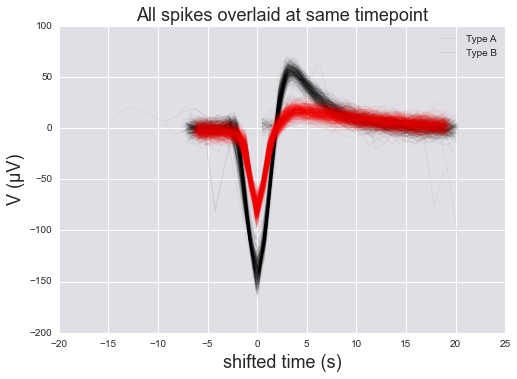

In [41]:
for spike in df_type_a['spike'].unique():
    V_vals = df_type_a[df_type_a['spike']==spike]['V (µV)'].values
    t_vals = df_type_a['spike'] == spike
    plt.plot(np.arange(t_vals.sum())- minimum(np.arange(t_vals.sum()), V_vals), df_type_a['V (µV)'][t_vals], \
             lw=1, alpha=0.05, color='black')

for spike in df_type_b['spike'].unique():
    V_vals = df_type_b[df_type_b['spike']==spike]['V (µV)'].values
    t_vals = df_type_b['spike'] == spike
    plt.plot(np.arange(t_vals.sum()) - minimum(np.arange(t_vals.sum()), V_vals), df_type_b['V (µV)'][t_vals], \
             lw=1, alpha=0.05, color='red')
    plt.xlabel('shifted time (s)')
    plt.ylabel('V (µV)')

plt.title("All spikes overlaid at same timepoint")


# c)
To plot the empirical probability distribution of the inter-spike times, we need to calculate the inter-spike times first.

In [64]:
# create an empty array for the spike poisitons
spikes_a = np.empty(len(df_type_a['spike'].unique()))

# find the local minimum
for i, spike in enumerate(df_type_a['spike'].unique()):
    inds = df_type_a['spike'] == spike
    spikes_a [i] = minimum(df_type_a['t (s)'][inds].values, df_type_a['V (µV)'][inds].values)

# Compute interspike times
spikes_a = np.sort(spikes_a)
interspike_times_a = np.diff(spikes_a)

# create an empty array for the spike poisitons
spikes_b = np.empty(len(df_type_b['spike'].unique()))

# find the local minimum
for i, spike in enumerate(df_type_b['spike'].unique()):
    inds = df_type_b['spike'] == spike
    spikes_b [i] = minimum(df_type_b['t (s)'][inds].values, df_type_b['V (µV)'][inds].values)

# Compute interspike times
spikes_b = np.sort(spikes_b)
interspike_times_b = np.diff(spikes_b)

Now we can calculate and plot the ECDFs.

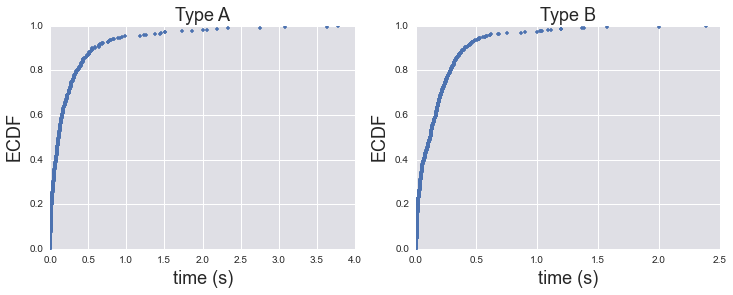

In [67]:
# let's plot the two graphs
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# plot the ECDF
x = np.sort(interspike_times_a)
y = np.arange(len(x)) / len(x)
ax[0].plot(x, y, '.')
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('ECDF')
ax[0].set_title('Type A')

# plot the ECDF
a = np.sort(interspike_times_b)
b = np.arange(len(a)) / len(a)
ax[1].plot(a, b, '.')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('ECDF')
ax[1].set_title('Type B')

Looking at the ECDFs, it appears that type B spikes tend to happen slightly closer to each other than type A spikes, and also the type A distribution has a longer tail to the right (larger interspike times). This makes sense since Type A spikes seem to deploarize more than type B spikes thus the cell needs to wait longer to regenerate enough potential for another action potential.